# Comprehensive Model Evaluation

This notebook evaluates all three trained models for the Agro Edge AI system:

1. **Disease Detection Model** - Multiclass classification (Tomato diseases)
2. **Irrigation Control Model** - Binary classification (Pump ON/OFF)
3. **Tomato Suitability Model** - Binary classification (Suitable/Unsuitable)

For each model, we compute appropriate evaluation metrics and visualize the confusion matrix.

---

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

PROJECT_DIR = ".."
print("Libraries loaded successfully.")

2026-02-09 07:34:34.138518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770602674.338279    3587 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770602674.386826    3587 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770602674.747933    3587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770602674.748023    3587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770602674.748029    3587 computation_placer.cc:177] computation placer alr

Libraries loaded successfully.


---

## 2. Disease Detection Model Evaluation

**Model:** MobileNetV2-based multiclass classifier (TFLite)  
**Task:** Classify tomato leaf images into disease categories  
**Key Metrics:** Confusion Matrix (per-class errors), Recall (catch all diseases), Weighted F1

In [2]:
# Load Disease Detection TFLite Model
DISEASE_MODEL_PATH = f"{PROJECT_DIR}/models/tomato_disease_multiclass_model.tflite"
DISEASE_DATA_DIR = f"{PROJECT_DIR}/data/processed/tomato_disease"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

# Load TFLite interpreter
interpreter = tf.lite.Interpreter(model_path=DISEASE_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Model loaded: {DISEASE_MODEL_PATH}")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Output shape: {output_details[0]['shape']}")

Model loaded: ../models/tomato_disease_multiclass_model.tflite
Input shape: [  1 224 224   3]
Output shape: [1 6]


/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DISEASE_DATA_DIR}/test",
    labels="inferred",
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = test_ds.class_names
num_classes = len(class_names)
print(f"Classes ({num_classes}): {class_names}")

Found 4329 files belonging to 6 classes.
Classes (6): ['Healthy', 'Leaf_Mold', 'Leaf_blight', 'Septoria_leaf_spot', 'Verticillium_wilt', 'Yellow_Leaf_Curl_Virus']


I0000 00:00:1770602679.083398    3587 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:02:00.0, compute capability: 6.1


In [4]:
# Run inference on test set using TFLite
# NOTE: The TFLite model already contains a Rescaling(1./255) layer,
# so we feed raw [0, 255] pixel values — do NOT divide by 255 again.
y_true_disease = []
y_pred_disease = []

for images, labels in test_ds:
    for i in range(images.shape[0]):
        # Feed raw pixel values (model handles normalization internally)
        img = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)
        
        # Run inference
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        
        y_pred_disease.append(np.argmax(output[0]))
        y_true_disease.append(np.argmax(labels[i].numpy()))

y_true_disease = np.array(y_true_disease)
y_pred_disease = np.array(y_pred_disease)

print(f"Evaluated {len(y_true_disease)} test samples")

Evaluated 4329 test samples


2026-02-09 07:35:22.029438: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Disease Detection Metrics
disease_accuracy = accuracy_score(y_true_disease, y_pred_disease)
disease_precision = precision_score(y_true_disease, y_pred_disease, average='weighted')
disease_recall = recall_score(y_true_disease, y_pred_disease, average='weighted')
disease_f1 = f1_score(y_true_disease, y_pred_disease, average='weighted')

print("=" * 60)
print("DISEASE DETECTION MODEL - EVALUATION METRICS")
print("=" * 60)
print(f"Accuracy:  {disease_accuracy:.4f}")
print(f"Precision: {disease_precision:.4f}")
print(f"Recall:    {disease_recall:.4f}  ← Critical: Catch all diseases!")
print(f"F1 Score:  {disease_f1:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_true_disease, y_pred_disease, target_names=class_names, digits=4))

DISEASE DETECTION MODEL - EVALUATION METRICS
Accuracy:  0.8055
Precision: 0.8092
Recall:    0.8055  ← Critical: Catch all diseases!
F1 Score:  0.8061

--- Classification Report ---
                        precision    recall  f1-score   support

               Healthy     0.9538    0.9749    0.9642      1314
             Leaf_Mold     0.9000    0.9375    0.9184        96
           Leaf_blight     0.8069    0.7045    0.7523      1056
    Septoria_leaf_spot     0.7623    0.7763    0.7692      1314
     Verticillium_wilt     0.5359    0.6333    0.5806       330
Yellow_Leaf_Curl_Virus     0.6059    0.6530    0.6286       219

              accuracy                         0.8055      4329
             macro avg     0.7608    0.7799    0.7689      4329
          weighted avg     0.8092    0.8055    0.8061      4329



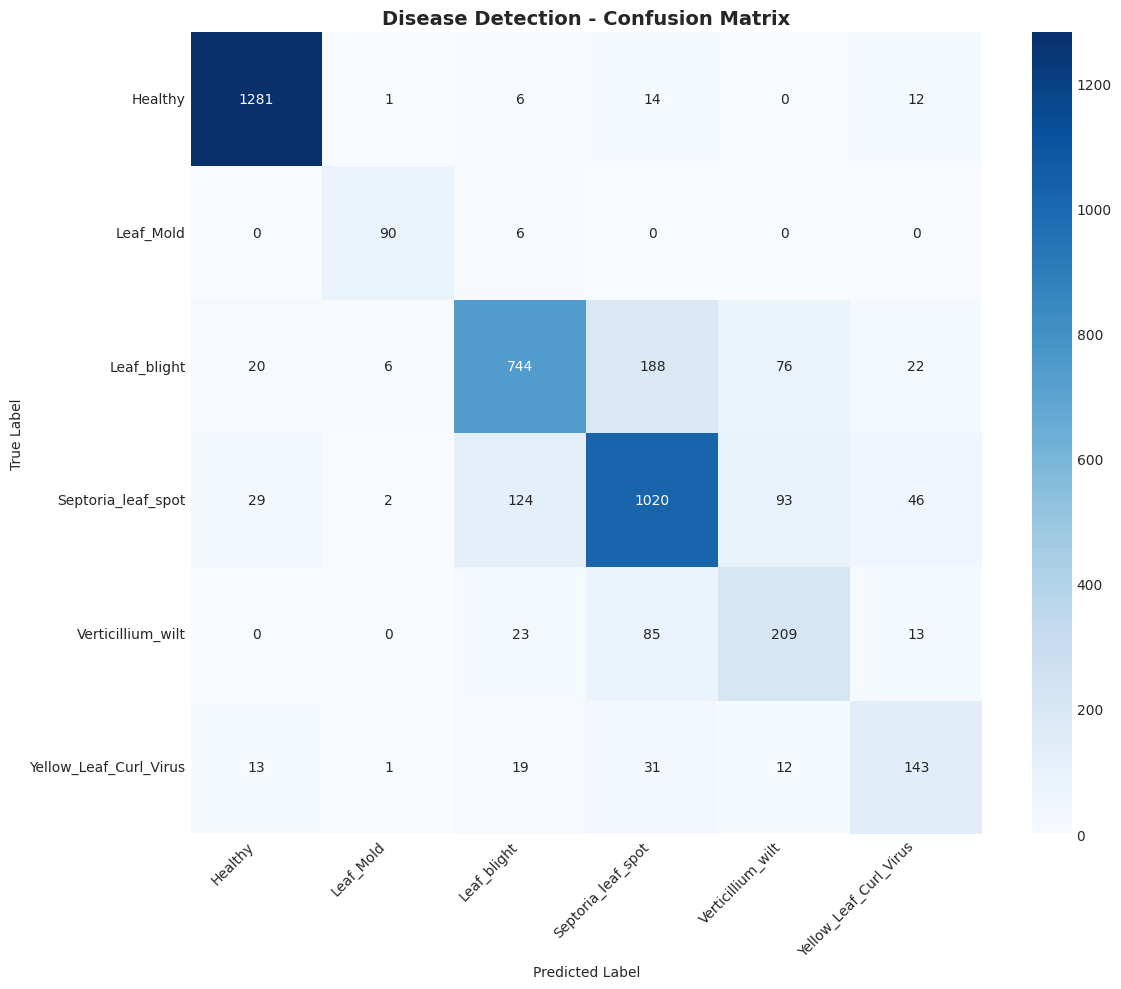


--- Most Confused Classes ---
'Leaf_blight' most often confused with 'Septoria_leaf_spot'


In [6]:
# Disease Detection Confusion Matrix
cm_disease = confusion_matrix(y_true_disease, y_pred_disease)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_disease, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Disease Detection - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Highlight most confused classes
print("\n--- Most Confused Classes ---")
np.fill_diagonal(cm_disease, 0)  # Remove correct predictions
max_confusion_idx = np.unravel_index(np.argmax(cm_disease), cm_disease.shape)
if cm_disease[max_confusion_idx] > 0:
    print(f"'{class_names[max_confusion_idx[0]]}' most often confused with '{class_names[max_confusion_idx[1]]}'")

---

## 3. Irrigation Control Model Evaluation

**Model:** Decision Tree Classifier  
**Task:** Predict whether to turn the irrigation pump ON or OFF  
**Key Metrics:** Precision (avoid false alarms/wasted water), Recall (never miss dry soil)

In [7]:
# Load Irrigation Model
IRRIGATION_MODEL_PATH = f"{PROJECT_DIR}/models/irrigation_dt.pkl"
IRRIGATION_DATA_PATH = f"{PROJECT_DIR}/data/raw/irrigation.csv"

irrigation_model = joblib.load(IRRIGATION_MODEL_PATH)
irrigation_data = pd.read_csv(IRRIGATION_DATA_PATH)

print(f"Model loaded: {IRRIGATION_MODEL_PATH}")
print(f"Dataset shape: {irrigation_data.shape}")
irrigation_data.head()

Model loaded: ../models/irrigation_dt.pkl
Dataset shape: (3000, 4)


,Soil Moisture,Temperature,Air Humidity,Pump Data
0,683.802906,29.184908,71.789699,0
1,408.571567,33.707205,77.977391,1
2,659.092074,24.760311,60.776282,1
3,842.929764,32.738515,59.323543,0
4,414.199320,25.692744,66.624914,1


In [8]:
# Prepare data and evaluate
X_irrigation = irrigation_data[["Soil Moisture", "Temperature", "Air Humidity"]]
y_irrigation = irrigation_data["Pump Data"]

# Split for evaluation (same as training notebook)
X_train_irr, X_test_irr, y_train_irr, y_test_irr = train_test_split(
    X_irrigation, y_irrigation, test_size=0.2, random_state=42, stratify=y_irrigation
)

# Predictions
y_pred_irrigation = irrigation_model.predict(X_test_irr)

# Metrics
irr_accuracy = accuracy_score(y_test_irr, y_pred_irrigation)
irr_precision = precision_score(y_test_irr, y_pred_irrigation)
irr_recall = recall_score(y_test_irr, y_pred_irrigation)
irr_f1 = f1_score(y_test_irr, y_pred_irrigation)

print("=" * 60)
print("IRRIGATION CONTROL MODEL - EVALUATION METRICS")
print("=" * 60)
print(f"Accuracy:  {irr_accuracy:.4f}")
print(f"Precision: {irr_precision:.4f}  ← Water efficiency (avoid waste)")
print(f"Recall:    {irr_recall:.4f}  ← Plant safety (catch all dry soil)")
print(f"F1 Score:  {irr_f1:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test_irr, y_pred_irrigation, target_names=["Pump OFF", "Pump ON"], digits=4))

IRRIGATION CONTROL MODEL - EVALUATION METRICS
Accuracy:  0.9983
Precision: 1.0000  ← Water efficiency (avoid waste)
Recall:    0.9968  ← Plant safety (catch all dry soil)
F1 Score:  0.9984

--- Classification Report ---
              precision    recall  f1-score   support

    Pump OFF     0.9965    1.0000    0.9983       286
     Pump ON     1.0000    0.9968    0.9984       314

    accuracy                         0.9983       600
   macro avg     0.9983    0.9984    0.9983       600
weighted avg     0.9983    0.9983    0.9983       600



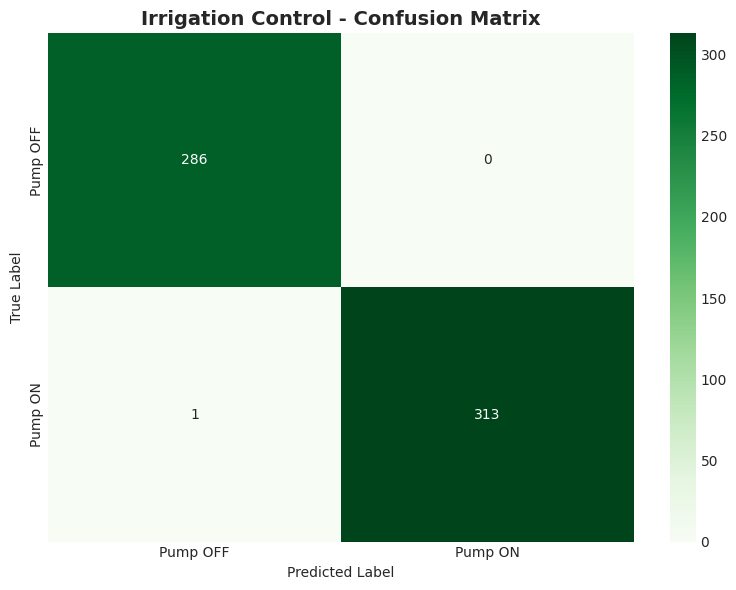


--- Error Interpretation ---
False Positives (Top-Right): 0 - Watered when NOT needed (Water Waste)
False Negatives (Bottom-Left): 1 - Did NOT water when needed (Plant Risk)


In [9]:
# Irrigation Confusion Matrix
cm_irrigation = confusion_matrix(y_test_irr, y_pred_irrigation)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_irrigation, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Pump OFF", "Pump ON"], yticklabels=["Pump OFF", "Pump ON"])
plt.title('Irrigation Control - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Interpretation
print("\n--- Error Interpretation ---")
print(f"False Positives (Top-Right): {cm_irrigation[0, 1]} - Watered when NOT needed (Water Waste)")
print(f"False Negatives (Bottom-Left): {cm_irrigation[1, 0]} - Did NOT water when needed (Plant Risk)")

---

## 4. Tomato Suitability Model Evaluation

**Model:** Random Forest / Decision Tree Binary Classifier  
**Task:** Predict if environmental conditions are suitable for tomato cultivation  
**Key Metrics:** ROC-AUC (probability calibration), Precision (avoid false recommendations)

In [10]:
# Load Suitability Models
SUITABILITY_RF_PATH = f"{PROJECT_DIR}/models/tomato_suitability_rf.pkl"
SUITABILITY_DT_PATH = f"{PROJECT_DIR}/models/tomato_suitability_dt.pkl"
SUITABILITY_DATA_PATH = f"{PROJECT_DIR}/data/processed/augmented_tomato_dataset.csv"

# Load models (try RF first, fallback to generic model)
try:
    suitability_rf = joblib.load(SUITABILITY_RF_PATH)
    suitability_dt = joblib.load(SUITABILITY_DT_PATH)
    print("Loaded both RF and DT suitability models")
except FileNotFoundError:
    suitability_rf = joblib.load(f"{PROJECT_DIR}/models/tomato_suitability_model.pkl")
    suitability_dt = None
    print("Loaded generic suitability model")

# Load data
suitability_data = pd.read_csv(SUITABILITY_DATA_PATH)
print(f"Dataset shape: {suitability_data.shape}")
suitability_data.head()

Loaded both RF and DT suitability models
Dataset shape: (20000, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,66.956865,124.304105,142.802636,19.826931,69.841422,5.961272,1425.003510,0
1,125.744621,68.941417,151.821413,23.519353,71.090225,6.117120,924.413622,1
2,192.934933,88.608519,154.462471,27.517464,72.071088,6.257890,1338.488015,0
3,133.478451,84.669761,176.599280,22.611216,79.865458,6.541192,715.097319,1
4,238.503420,6.076627,248.056945,13.789859,100.000000,7.999724,2991.243186,0


In [11]:
# Prepare suitability data
if 'label' in suitability_data.columns:
    if suitability_data['label'].dtype == 'object':
        suitability_data['is_tomato'] = (suitability_data['label'] == 'tomato').astype(int)
    else:
        suitability_data['is_tomato'] = suitability_data['label'].astype(int)
    suitability_data = suitability_data.drop('label', axis=1)

X_suit = suitability_data.drop(['is_tomato'], axis=1)
y_suit = suitability_data['is_tomato']

# Split for evaluation
X_train_suit, X_test_suit, y_train_suit, y_test_suit = train_test_split(
    X_suit, y_suit, test_size=0.2, random_state=42, stratify=y_suit
)

print(f"Test samples: {len(y_test_suit)}")
print(f"Class distribution: {y_test_suit.value_counts().to_dict()}")

Test samples: 4000
Class distribution: {0: 2369, 1: 1631}


In [12]:
# Evaluate Random Forest Model
y_pred_suit = suitability_rf.predict(X_test_suit)
y_proba_suit = suitability_rf.predict_proba(X_test_suit)[:, 1]

suit_accuracy = accuracy_score(y_test_suit, y_pred_suit)
suit_precision = precision_score(y_test_suit, y_pred_suit)
suit_recall = recall_score(y_test_suit, y_pred_suit)
suit_f1 = f1_score(y_test_suit, y_pred_suit)
suit_roc_auc = roc_auc_score(y_test_suit, y_proba_suit)

print("=" * 60)
print("TOMATO SUITABILITY MODEL (RF) - EVALUATION METRICS")
print("=" * 60)
print(f"Accuracy:  {suit_accuracy:.4f}")
print(f"Precision: {suit_precision:.4f}  ← Avoid wrong recommendations")
print(f"Recall:    {suit_recall:.4f}")
print(f"F1 Score:  {suit_f1:.4f}")
print(f"ROC-AUC:   {suit_roc_auc:.4f}  ← Probability calibration quality")
print("\n--- Classification Report ---")
print(classification_report(y_test_suit, y_pred_suit, target_names=["Not Suitable", "Suitable"], digits=4))

TOMATO SUITABILITY MODEL (RF) - EVALUATION METRICS
Accuracy:  0.9030
Precision: 0.8482  ← Avoid wrong recommendations
Recall:    0.9283
F1 Score:  0.8864
ROC-AUC:   0.9522  ← Probability calibration quality

--- Classification Report ---
              precision    recall  f1-score   support

Not Suitable     0.9472    0.8856    0.9154      2369
    Suitable     0.8482    0.9283    0.8864      1631

    accuracy                         0.9030      4000
   macro avg     0.8977    0.9069    0.9009      4000
weighted avg     0.9068    0.9030    0.9036      4000



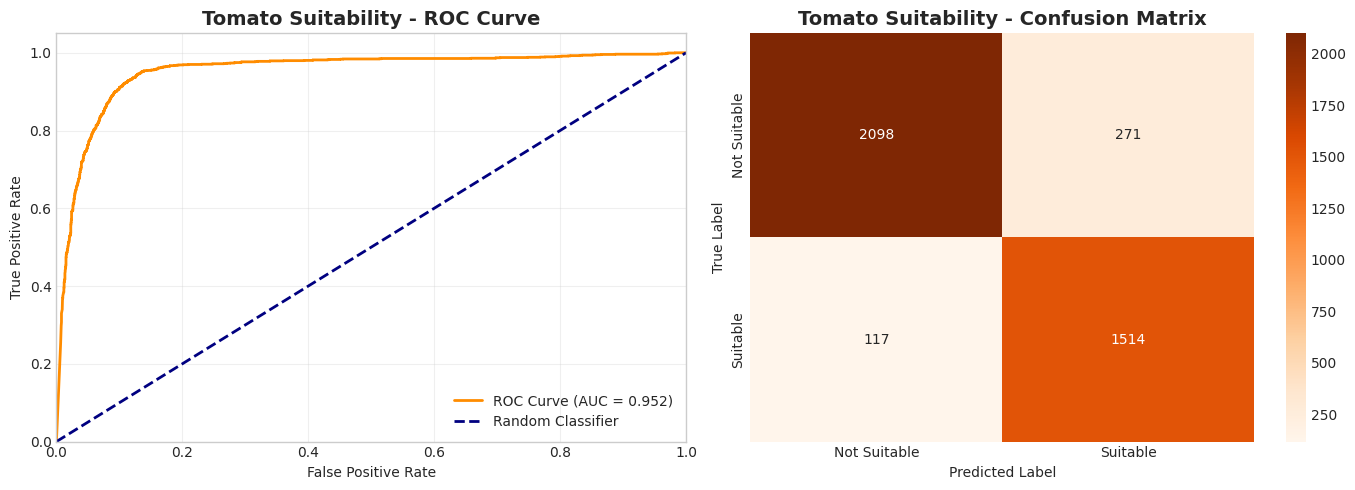

In [13]:
# ROC Curve and Confusion Matrix for Suitability Model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_suit, y_proba_suit)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {suit_roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Tomato Suitability - ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm_suit = confusion_matrix(y_test_suit, y_pred_suit)
sns.heatmap(cm_suit, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Not Suitable", "Suitable"], yticklabels=["Not Suitable", "Suitable"], ax=axes[1])
axes[1].set_title('Tomato Suitability - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

---

## 5. Summary: Model Comparison

A consolidated view of all three models' performance metrics.

In [16]:
# Summary Comparison Table
summary_data = {
    'Model': ['Disease Detection', 'Irrigation Control', 'Tomato Suitability'],
    'Type': ['Multiclass', 'Binary', 'Binary'],
    'Accuracy': [disease_accuracy, irr_accuracy, suit_accuracy],
    'Precision': [disease_precision, irr_precision, suit_precision],
    'Recall': [disease_recall, irr_recall, suit_recall],
    'F1 Score': [disease_f1, irr_f1, suit_f1],
    'Key Metric': ['Recall (catch diseases)', 'Recall (plant safety)', 'ROC-AUC (probability)']
}

summary_df = pd.DataFrame(summary_data)

# Format as percentages with 2 decimal places (e.g., 99.83%)
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    summary_df[col] = summary_df[col].apply(lambda x: f"{x * 100:.2f}%")

print("=" * 80)
print("MODEL EVALUATION SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("\n" + "=" * 80)

MODEL EVALUATION SUMMARY
             Model       Type Accuracy Precision Recall F1 Score              Key Metric
 Disease Detection Multiclass   80.55%    80.92% 80.55%   80.61% Recall (catch diseases)
Irrigation Control     Binary   99.83%   100.00% 99.68%   99.84%   Recall (plant safety)
Tomato Suitability     Binary   90.30%    84.82% 92.83%   88.64%   ROC-AUC (probability)



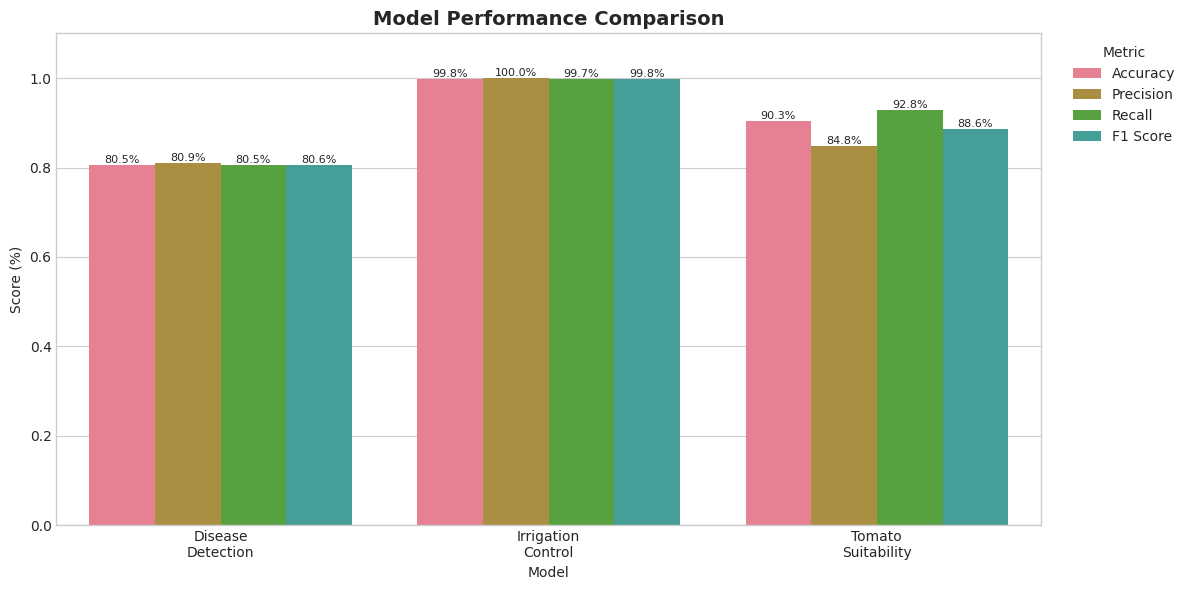


✓ Evaluation complete. All models have been assessed with appropriate metrics.


In [17]:
# Visual Comparison
metrics_for_plot = pd.DataFrame({
    'Model': ['Disease\nDetection', 'Irrigation\nControl', 'Tomato\nSuitability'] * 4,
    'Metric': ['Accuracy'] * 3 + ['Precision'] * 3 + ['Recall'] * 3 + ['F1 Score'] * 3,
    'Score': [disease_accuracy, irr_accuracy, suit_accuracy,
              disease_precision, irr_precision, suit_precision,
              disease_recall, irr_recall, suit_recall,
              disease_f1, irr_f1, suit_f1]
})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=metrics_for_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.ylim(0, 1.1)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{x*100:.1f}%', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete. All models have been assessed with appropriate metrics.")